In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda


In [2]:
# Load processed traffic data
import os

data_path = 'data/processed/traffic_data_processed.csv'
df = pd.read_csv(data_path, parse_dates=['start_time'])

print(f"Dataset shape: {df.shape}")
print(f"\nDate range: {df['start_time'].min()} to {df['start_time'].max()}")
print(f"Total days: {(df['start_time'].max() - df['start_time'].min()).days}")
print(f"\nFirst few rows:")
print(df.head(10))
print(f"\nData statistics:")
print(df[['cpu', 'memory']].describe())

features = df[['cpu', 'memory']].values

# Normalize using MinMaxScaler
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

print(f"\nNormalized data shape: {features_normalized.shape}")

Dataset shape: (17280, 3)

Date range: 2019-04-30 23:55:00 to 2019-06-29 23:50:00
Total days: 59

First few rows:
           start_time       cpu    memory
0 2019-04-30 23:55:00  0.007980  0.001450
1 2019-05-01 00:00:00  0.002263  0.000516
2 2019-05-01 00:05:00  0.001518  0.000290
3 2019-05-01 00:10:00  0.001718  0.000459
4 2019-05-01 00:15:00  0.003867  0.000741
5 2019-05-01 00:20:00  0.006322  0.000850
6 2019-05-01 00:25:00  0.003980  0.000888
7 2019-05-01 00:30:00  0.003295  0.000810
8 2019-05-01 00:35:00  0.002720  0.000458
9 2019-05-01 00:40:00  0.002383  0.000584

Data statistics:
                cpu        memory
count  17280.000000  17280.000000
mean       0.023135      0.004622
std        0.023967      0.004834
min        0.000378      0.000070
25%        0.004750      0.000938
50%        0.014388      0.002860
75%        0.035009      0.006893
max        0.325496      0.057081

Normalized data shape: (17280, 2)


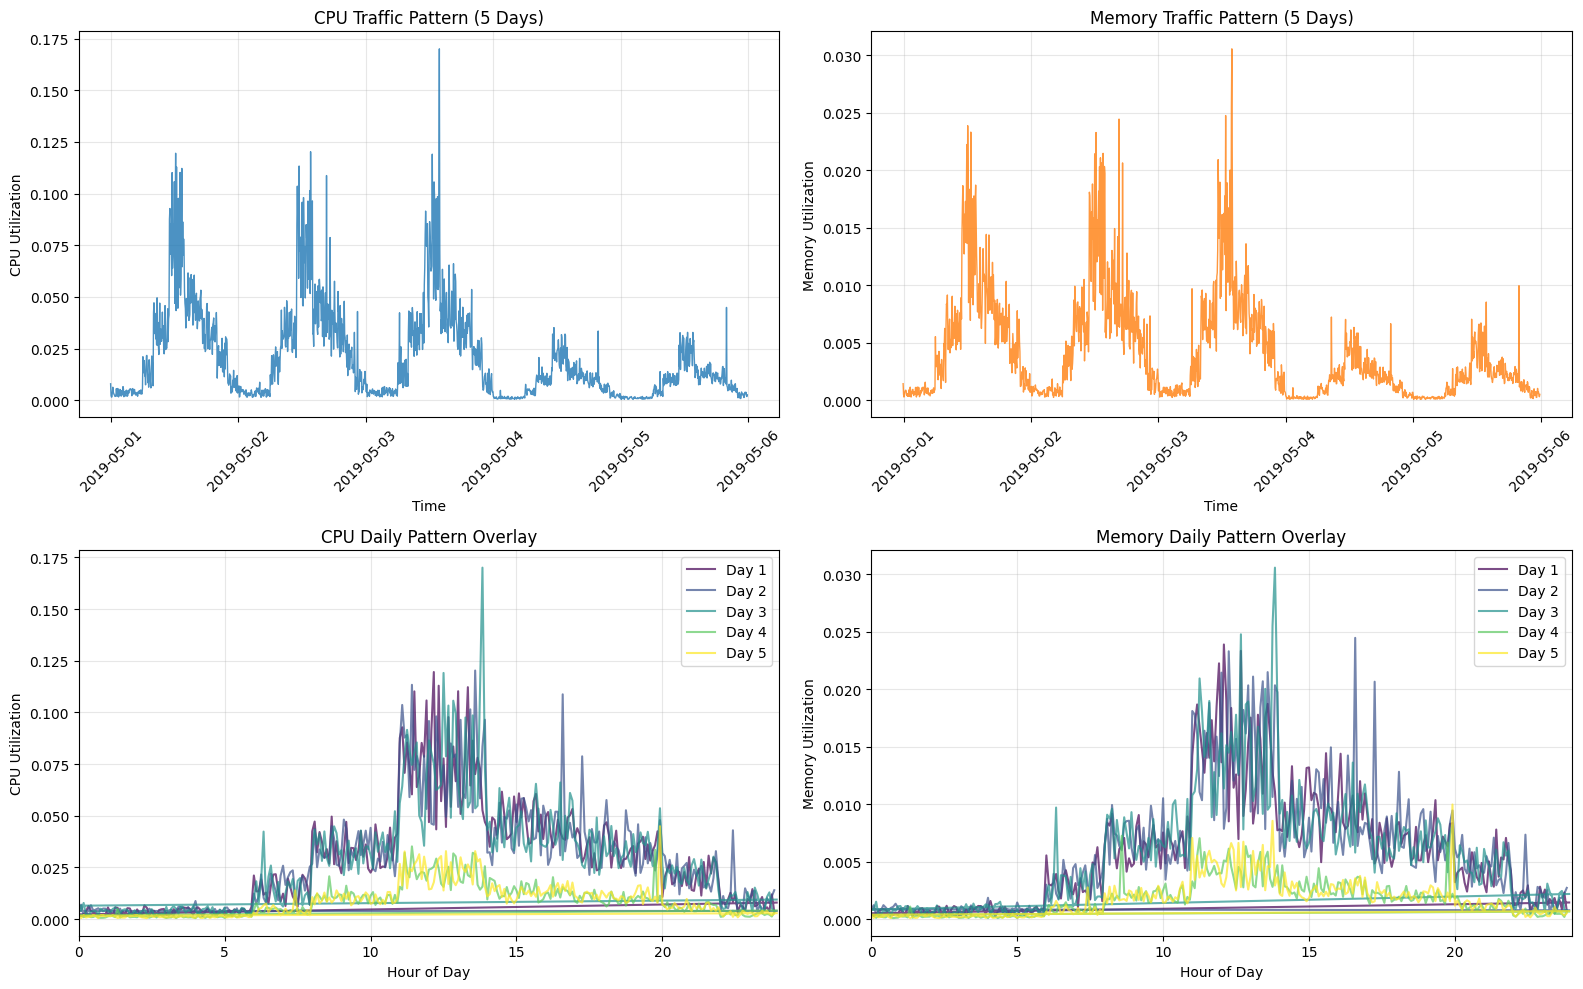

Showing 1440 samples (5 days)
Date range shown: 2019-04-30 23:55:00 to 2019-05-05 23:50:00


In [3]:
# Visualize traffic patterns for 5 days
# Show CPU and memory trends to understand data characteristics

# Select first 5 days of data (5 days * 24 hours * 12 samples/hour = 1440 samples)
samples_per_day = 24 * 12  # 288 samples per day (5-min intervals)
n_days = 5
n_samples = samples_per_day * n_days

df_5days = df.head(n_samples).copy()
df_5days['day'] = (df_5days['start_time'] - df_5days['start_time'].min()).dt.days
df_5days['hour'] = df_5days['start_time'].dt.hour + df_5days['start_time'].dt.minute / 60

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# CPU over 5 days - continuous timeline
axes[0, 0].plot(df_5days['start_time'], df_5days['cpu'], linewidth=1, alpha=0.8, color='tab:blue')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('CPU Utilization')
axes[0, 0].set_title(f'CPU Traffic Pattern ({n_days} Days)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Memory over 5 days - continuous timeline
axes[0, 1].plot(df_5days['start_time'], df_5days['memory'], linewidth=1, alpha=0.8, color='tab:orange')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Memory Utilization')
axes[0, 1].set_title(f'Memory Traffic Pattern ({n_days} Days)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Daily overlay - CPU (each day as separate line)
colors = plt.cm.viridis(np.linspace(0, 1, n_days))
for day in range(n_days):
    day_data = df_5days[df_5days['day'] == day]
    axes[1, 0].plot(day_data['hour'], day_data['cpu'], linewidth=1.5, alpha=0.7, 
                    color=colors[day], label=f'Day {day+1}')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('CPU Utilization')
axes[1, 0].set_title('CPU Daily Pattern Overlay')
axes[1, 0].legend(loc='upper right')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim(0, 24)

# Daily overlay - Memory (each day as separate line)
for day in range(n_days):
    day_data = df_5days[df_5days['day'] == day]
    axes[1, 1].plot(day_data['hour'], day_data['memory'], linewidth=1.5, alpha=0.7,
                    color=colors[day], label=f'Day {day+1}')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Memory Utilization')
axes[1, 1].set_title('Memory Daily Pattern Overlay')
axes[1, 1].legend(loc='upper right')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(0, 24)

plt.tight_layout()
plt.show()

print(f"Showing {n_samples} samples ({n_days} days)")
print(f"Date range shown: {df_5days['start_time'].min()} to {df_5days['start_time'].max()}")

In [4]:
# Create OVERLAPPING sequences with stride=1 (sliding window)
# Increased lookback to 12 timesteps (1 hour)
def create_sequences_overlapping(data, seq_length=12, stride=1):
    """
    Create OVERLAPPING sequences for time series using sliding window.
    
    params:
        data: Normalized feature array (n_samples, n_features)
        seq_length: Number of timesteps in each sequence (default: 12 for 1 hour)
        stride: Step size between sequences (default: 1 for maximum overlap)
    
    returns:
        X: Input sequences (n_sequences, seq_length, n_features)
        y: Target values (n_sequences, n_features)
    """
    X, y = [], []
    
    for i in range(0, len(data) - seq_length, stride):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    
    return np.array(X), np.array(y)

SEQ_LENGTH = 12  # 1 hour lookback (12 x 5min)
STRIDE = 1       # Maximum overlap

X, y = create_sequences_overlapping(features_normalized, seq_length=SEQ_LENGTH, stride=STRIDE)

print(f"Input sequences shape: {X.shape}")
print(f"Target values shape: {y.shape}")
print(f"\nTotal sequences created: {len(X)}")
print(f"Each sequence has {SEQ_LENGTH} timesteps with {X.shape[2]} features")
print(f"\nWith overlapping (stride={STRIDE}): {len(features_normalized)} rows -> {len(X)} sequences")
print(f"Compared to non-overlapping: would be ~{len(features_normalized) // SEQ_LENGTH} sequences")
print(f"\nSample sequence (first):")
print(f"Input shape: {X[0].shape}")
print(f"Target: {y[0]}")

Input sequences shape: (17268, 12, 2)
Target values shape: (17268, 2)

Total sequences created: 17268
Each sequence has 12 timesteps with 2 features

With overlapping (stride=1): 17280 rows -> 17268 sequences
Compared to non-overlapping: would be ~1440 sequences

Sample sequence (first):
Input shape: (12, 2)
Target: [0.00495658 0.00506724]


In [5]:
# Split + dataloaders
# Use shuffle split to avoid data leakage from overlapping sequences
train_size = int(0.8 * len(X))

# Shuffle indices to break temporal correlation from overlapping
indices = np.random.permutation(len(X))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

print(f"Train set: {X_train.shape[0]} sequences")
print(f"Test set: {X_test.shape[0]} sequences")
print(f"Split ratio: {train_size/len(X)*100:.1f}% train, {(1-train_size/len(X))*100:.1f}% test")

X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Smaller batch size for better generalization
BATCH_SIZE = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Preview one batch
sample_batch_X, sample_batch_y = next(iter(train_loader))
print(f"\nSample batch shapes:")
print(f"  Input: {sample_batch_X.shape}")
print(f"  Target: {sample_batch_y.shape}")

Train set: 13814 sequences
Test set: 3454 sequences
Split ratio: 80.0% train, 20.0% test

Batch size: 16
Number of training batches: 864
Number of test batches: 216

Sample batch shapes:
  Input: torch.Size([16, 12, 2])
  Target: torch.Size([16, 2])


In [6]:
# Simplified LSTM Model Architecture with improvements
class TrafficPredictorV2(nn.Module):
    """
    Simplified LSTM model with architectural improvements:
    - Single LSTM layer (reduced from 2) to prevent overfitting
    - Bidirectional LSTM for better context
    - Layer normalization for stability
    - Higher dropout for regularization
    - Simpler dense head
    
    arch:
    - Input: (batch, seq_length=12, features=2)
    - Bidirectional LSTM: 32 hidden units
    - Layer Norm + Dropout
    - Dense: 64 -> 2 (CPU and memory predictions)
    """
    def __init__(self, input_size=2, hidden_size=32, dropout=0.4, output_size=2):
        super(TrafficPredictorV2, self).__init__()
        
        # Single bidirectional LSTM layer
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            batch_first=True,
            bidirectional=True
        )
        
        # Layer normalization for training stability
        self.layer_norm = nn.LayerNorm(hidden_size * 2)  # *2 for bidirectional
        
        # Higher dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Simplified dense head
        self.fc1 = nn.Linear(hidden_size * 2, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, output_size)
        
    def forward(self, x):
        # x shape: (batch, seq_length, features)
        
        # Bidirectional LSTM
        lstm_out, _ = self.lstm(x)
        
        # Take last timestep output
        last_output = lstm_out[:, -1, :]  # (batch, hidden_size * 2)
        
        # Layer norm + dropout
        out = self.layer_norm(last_output)
        out = self.dropout(out)
        
        # Dense layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)  # (batch, 2)
        
        return out

# Initialize model
model = TrafficPredictorV2().to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test forward pass
test_input = torch.randn(BATCH_SIZE, SEQ_LENGTH, 2).to(device)
test_output = model(test_input)
print(f"\nTest forward pass:")
print(f"  Input shape: {test_input.shape}")
print(f"  Output shape: {test_output.shape}")

Model Architecture:
TrafficPredictorV2(
  (lstm): LSTM(2, 32, batch_first=True, bidirectional=True)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

Total parameters: 11,490
Trainable parameters: 11,490

Test forward pass:
  Input shape: torch.Size([16, 12, 2])
  Output shape: torch.Size([16, 2])


In [7]:
# Loss function and optimizer with hyperparameter optimizations
criterion = nn.MSELoss()

# Adam with weight decay (L2 regularization) and lower learning rate
LEARNING_RATE = 0.0005
WEIGHT_DECAY = 1e-4

optimizer = optim.Adam(
    model.parameters(), 
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler - reduce on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5,
    verbose=True
)

# Training hyperparams
NUM_EPOCHS = 150
EARLY_STOP_PATIENCE = 20

print("Training Configuration:")
print(f"  Loss function: MSE (Mean Squared Error)")
print(f"  Optimizer: Adam with weight decay")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay (L2): {WEIGHT_DECAY}")
print(f"  LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")
print(f"  Number of epochs: {NUM_EPOCHS}")
print(f"  Early stopping patience: {EARLY_STOP_PATIENCE}")
print(f"  Device: {device}")

Training Configuration:
  Loss function: MSE (Mean Squared Error)
  Optimizer: Adam with weight decay
  Learning rate: 0.0005
  Weight decay (L2): 0.0001
  LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)
  Number of epochs: 150
  Early stopping patience: 20
  Device: cuda


c:\Users\Nathan\workspace_code\web-autoscaler\modeling\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [8]:
# Training loop with improvements
train_losses = []
test_losses = []
learning_rates = []
best_test_loss = float('inf')
patience_counter = 0

print("Starting training...\n")

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_loss += loss.item()
    
    # Average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluation on test set
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            test_loss += loss.item()
    
    # Average test loss
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    # Track learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    # Step scheduler
    scheduler.step(avg_test_loss)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}, LR: {current_lr:.6f}")
    
    # Early stopping check
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            print(f"Best test loss: {best_test_loss:.6f}")
            model.load_state_dict(best_model_state)
            break

print("\n" + "="*50)
print("Training Complete!")
print(f"Final Train Loss: {train_losses[-1]:.6f}")
print(f"Final Test Loss: {test_losses[-1]:.6f}")
print(f"Best Test Loss: {best_test_loss:.6f}")
print("="*50)

Starting training...

Epoch [1/150] - Train Loss: 0.008246, Test Loss: 0.002699, LR: 0.000500
Epoch [10/150] - Train Loss: 0.001861, Test Loss: 0.001593, LR: 0.000500
Epoch [20/150] - Train Loss: 0.001771, Test Loss: 0.001502, LR: 0.000500
Epoch [30/150] - Train Loss: 0.001756, Test Loss: 0.001514, LR: 0.000125

Early stopping triggered at epoch 34
Best test loss: 0.001474

Training Complete!
Final Train Loss: 0.001710
Final Test Loss: 0.001512
Best Test Loss: 0.001474


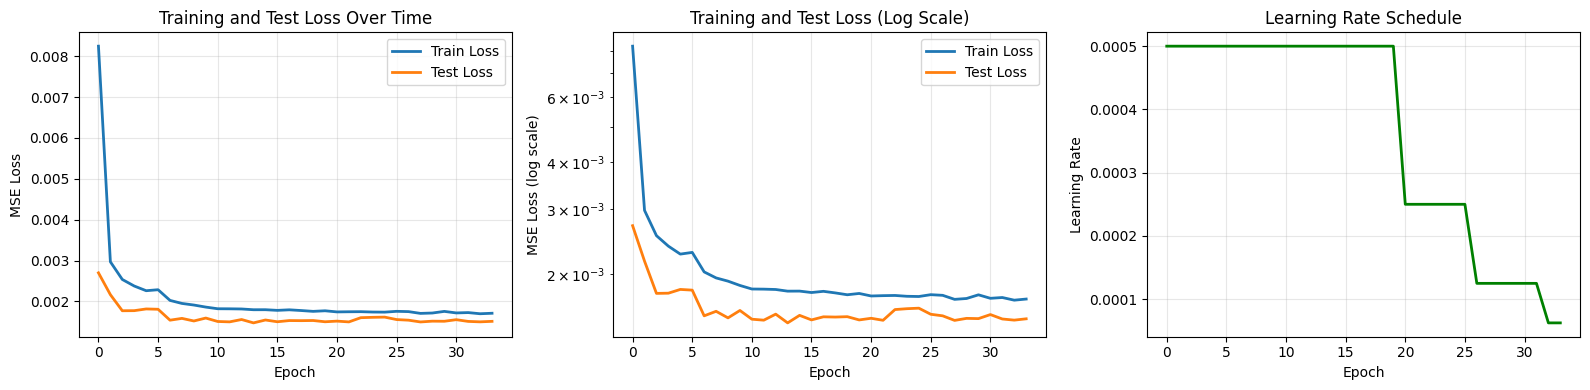

Total epochs trained: 34
Best test loss achieved: 0.001474 at epoch 14


In [9]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Loss curves
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(test_losses, label='Test Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training and Test Loss Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Log scale loss
axes[1].plot(train_losses, label='Train Loss', linewidth=2)
axes[1].plot(test_losses, label='Test Loss', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE Loss (log scale)')
axes[1].set_title('Training and Test Loss (Log Scale)')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning rate
axes[2].plot(learning_rates, linewidth=2, color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total epochs trained: {len(train_losses)}")
print(f"Best test loss achieved: {min(test_losses):.6f} at epoch {test_losses.index(min(test_losses))+1}")

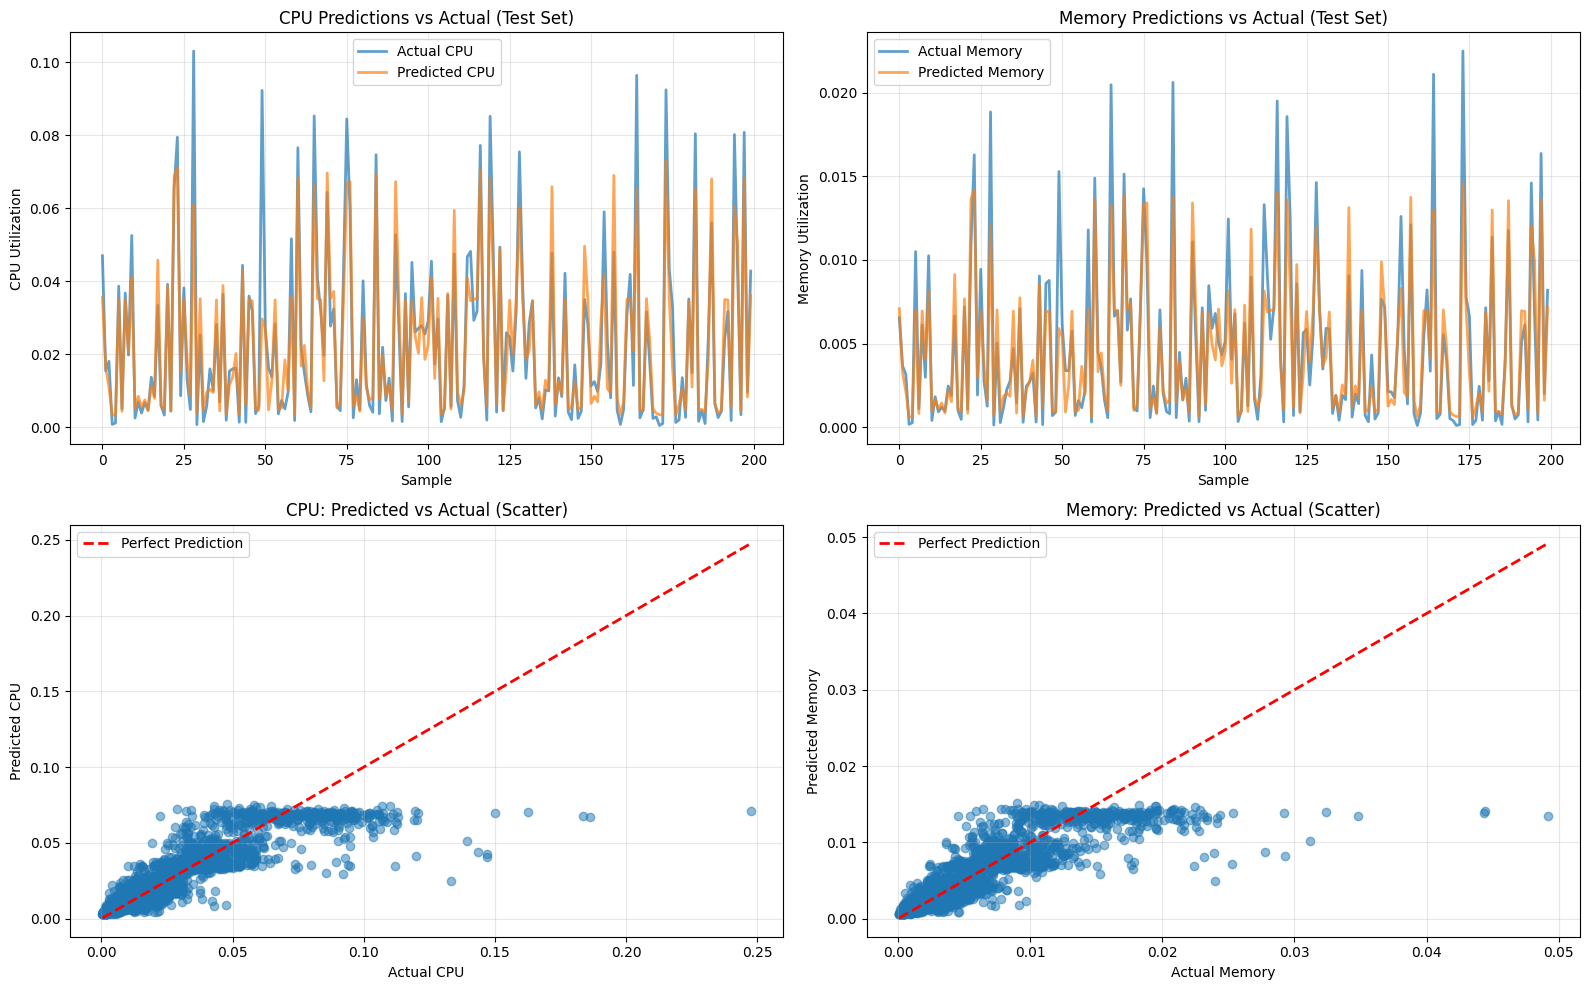

In [10]:
# Test predictions
model.eval()

with torch.no_grad():
    y_pred_test = model(X_test_tensor).cpu().numpy()
    y_true_test = y_test_tensor.cpu().numpy()

y_pred_actual = scaler.inverse_transform(y_pred_test)
y_true_actual = scaler.inverse_transform(y_true_test)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# CPU Predictions vs Actual (first 200 samples)
n_samples = min(200, len(y_true_actual))
axes[0, 0].plot(y_true_actual[:n_samples, 0], label='Actual CPU', linewidth=2, alpha=0.7)
axes[0, 0].plot(y_pred_actual[:n_samples, 0], label='Predicted CPU', linewidth=2, alpha=0.7)
axes[0, 0].set_xlabel('Sample')
axes[0, 0].set_ylabel('CPU Utilization')
axes[0, 0].set_title('CPU Predictions vs Actual (Test Set)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Memory Predictions vs Actual (first 200 samples)
axes[0, 1].plot(y_true_actual[:n_samples, 1], label='Actual Memory', linewidth=2, alpha=0.7)
axes[0, 1].plot(y_pred_actual[:n_samples, 1], label='Predicted Memory', linewidth=2, alpha=0.7)
axes[0, 1].set_xlabel('Sample')
axes[0, 1].set_ylabel('Memory Utilization')
axes[0, 1].set_title('Memory Predictions vs Actual (Test Set)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# CPU Scatter Plot
axes[1, 0].scatter(y_true_actual[:, 0], y_pred_actual[:, 0], alpha=0.5)
axes[1, 0].plot([y_true_actual[:, 0].min(), y_true_actual[:, 0].max()], 
                [y_true_actual[:, 0].min(), y_true_actual[:, 0].max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual CPU')
axes[1, 0].set_ylabel('Predicted CPU')
axes[1, 0].set_title('CPU: Predicted vs Actual (Scatter)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Memory Scatter Plot
axes[1, 1].scatter(y_true_actual[:, 1], y_pred_actual[:, 1], alpha=0.5)
axes[1, 1].plot([y_true_actual[:, 1].min(), y_true_actual[:, 1].max()], 
                [y_true_actual[:, 1].min(), y_true_actual[:, 1].max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Memory')
axes[1, 1].set_ylabel('Predicted Memory')
axes[1, 1].set_title('Memory: Predicted vs Actual (Scatter)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import r2_score, mean_absolute_error

# R² scores
r2_cpu = r2_score(y_true_actual[:, 0], y_pred_actual[:, 0])
r2_mem = r2_score(y_true_actual[:, 1], y_pred_actual[:, 1])

# MAE scores
mae_cpu = mean_absolute_error(y_true_actual[:, 0], y_pred_actual[:, 0])
mae_mem = mean_absolute_error(y_true_actual[:, 1], y_pred_actual[:, 1])

print("Model Performance Metrics:")
print(f"\nR² Scores:")
print(f"  CPU: {r2_cpu:.4f}")
print(f"  Memory: {r2_mem:.4f}")
print(f"\nMAE Scores:")
print(f"  CPU: {mae_cpu:.6f}")
print(f"  Memory: {mae_mem:.6f}")

Model Performance Metrics:

R² Scores:
  CPU: 0.7796
  Memory: 0.7659

MAE Scores:
  CPU: 0.006241
  Memory: 0.001293


In [12]:
# Export model, scaler, and config for inference
import pickle

# Create models directory
os.makedirs('models', exist_ok=True)

# Save model weights
model_path = 'models/traffic_predictor_v3.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Save scaler for inference
scaler_path = 'models/scaler_v3.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to {scaler_path}")

# Save model config
config = {
    'model_version': 'v3',
    'input_size': 2,
    'hidden_size': 32,
    'dropout': 0.4,
    'output_size': 2,
    'bidirectional': True,
    'seq_length': SEQ_LENGTH,
    'stride': STRIDE,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'weight_decay': WEIGHT_DECAY,
    'best_test_loss': best_test_loss,
    'r2_cpu': r2_cpu,
    'r2_memory': r2_mem
}

config_path = 'models/config_v3.pkl'
with open(config_path, 'wb') as f:
    pickle.dump(config, f)
print(f"Config saved to {config_path}")

print(f"\nAll artifacts exported to models/ directory")
print(f"\nModel config:")
for k, v in config.items():
    print(f"  {k}: {v}")

Model saved to models/traffic_predictor_v3.pth
Scaler saved to models/scaler_v3.pkl
Config saved to models/config_v3.pkl

All artifacts exported to models/ directory

Model config:
  model_version: v3
  input_size: 2
  hidden_size: 32
  dropout: 0.4
  output_size: 2
  bidirectional: True
  seq_length: 12
  stride: 1
  batch_size: 16
  learning_rate: 0.0005
  weight_decay: 0.0001
  best_test_loss: 0.0014744534592291867
  r2_cpu: 0.7796344757080078
  r2_memory: 0.7659474611282349
